In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.impute import SimpleImputer

Будем учиться классифицировать жанры музыки, полузуюсь не аудио дорожками, а уже осмысленными признаками (правда, не все из них имеют понятные названия). Сами данные можно найти [здесь](https://www.kaggle.com/purumalgi/music-genre-classification). Будем использовать файл `train.csv`. Нашей задачей будет предсказание переменной `Class` (жанр песни) при помощи деревьев решений. Можно попробовать также другие методы классификации, которые мы прошли, и сравнить результаты. При обучении всех моделей не забывайте про разделение на тренировку и тест (или кросс валидацию [ссылка](https://www.youtube.com/watch?v=fSytzGwwBVw)).

### Задание 1. EDA (10 баллов)

Как обычно, начнем с того, что посмотрим на наши данные: типы переменных, пропущенные значения, баланс классов и все такое. Ваш ход:

In [2]:
data = pd.read_csv("../data/train.csv")
data.head()

,Artist Name,Track Name,Popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_in min/ms,time_signature,Class
0,Bruno Mars,That's What I Like (feat. Gucci Mane),60.0,0.854,0.564,1.0,-4.964,1,0.0485,0.017100,NaN,0.0849,0.8990,134.071,234596.0,4,5
1,Boston,Hitch a Ride,54.0,0.382,0.814,3.0,-7.230,1,0.0406,0.001100,0.004010,0.1010,0.5690,116.454,251733.0,4,10
2,The Raincoats,No Side to Fall In,35.0,0.434,0.614,6.0,-8.334,1,0.0525,0.486000,0.000196,0.3940,0.7870,147.681,109667.0,4,6
3,Deno,Lingo (feat. J.I & Chunkz),66.0,0.853,0.597,10.0,-6.528,0,0.0555,0.021200,NaN,0.1220,0.5690,107.033,173968.0,4,5
4,Red Hot Chili Peppers,Nobody Weird Like Me - Remastered,53.0,0.167,0.975,2.0,-4.279,1,0.2160,0.000169,0.016100,0.1720,0.0918,199.060,229960.0,4,10


In [3]:
from my_awesome_eda import run_eda
df = data
run_eda(df)

In the observed table 
The number of observations/rows is 17996 
The number of parameters/columns is 17

Number of unique values in column Artist Name: 9149
Number of unique values in column Track Name: 15129
Number of unique values in column Popularity: 100
Number of unique values in column danceability: 909
Number of unique values in column energy: 1208
Number of unique values in column key: 11
Number of unique values in column loudness: 9002
Number of unique values in column mode: 2
Number of unique values in column speechiness: 1194
Number of unique values in column acousticness: 3930
Number of unique values in column instrumentalness: 4253
Number of unique values in column liveness: 1459
Number of unique values in column valence: 1320
Number of unique values in column tempo: 13562
Number of unique values in column duration_in min/ms: 14121
Number of unique values in column time_signature: 4
Number of unique values in column Class: 11

Categorical columns:['key', 'mode', 'time_sign

,count,mean,std,min,25%,50%,75%,max
Popularity,17568.0,44.512124,17.426928,1.000000,33.000000,44.00000,56.00000,100.000
danceability,17996.0,0.543433,0.166268,0.059600,0.432000,0.54500,0.65900,0.989
energy,17996.0,0.662777,0.235373,0.000020,0.509000,0.70000,0.86000,1.000
key,15982.0,5.952447,3.196854,1.000000,3.000000,6.00000,9.00000,11.000
loudness,17996.0,-7.910660,4.049151,-39.952000,-9.538000,-7.01600,-5.18900,1.355
mode,17996.0,0.636753,0.480949,0.000000,0.000000,1.00000,1.00000,1.000
speechiness,17996.0,0.079707,0.083576,0.022500,0.034800,0.04740,0.08300,0.955
acousticness,17996.0,0.247082,0.310632,0.000000,0.004300,0.08140,0.43400,0.996
instrumentalness,13619.0,0.177562,0.304048,0.000001,0.000089,0.00391,0.20000,0.996
liveness,17996.0,0.196170,0.159212,0.011900,0.097500,0.12900,0.25800,1.000


Column 'Popularity' has 428 missing values.
Column 'key' has 2014 missing values.
Column 'instrumentalness' has 4377 missing values.

Number of duplicate rows: 0


Разбреремся с пропущенными значениями. Я еще проверяла модель в случае если просто дропнуть все NA, результат в итоге получился такой же как с SimpleImputer.

In [4]:
cleaned_data = df.dropna()

Посмотрим распределение данных для численных значений

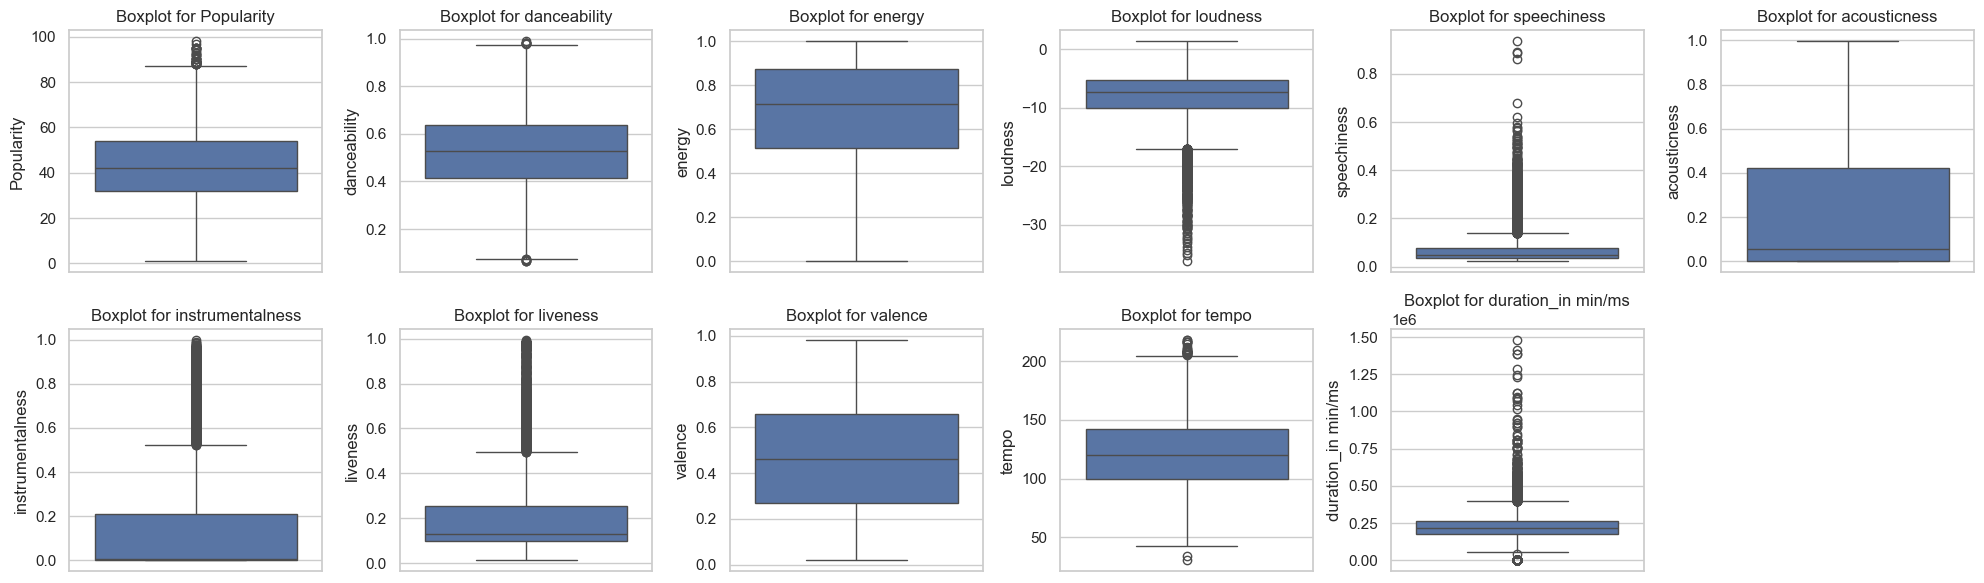

In [5]:
sns.set(style="whitegrid")
numerical_columns = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                     'duration_in min/ms']

plt.figure(figsize=(20, 6))
for i, column in enumerate(numerical_columns):
    plt.subplot(2, 6, i+1)
    sns.boxplot(y=cleaned_data[column])
    plt.title(f"Boxplot for {column}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Удалим данные, которые выглядят как выбросы

In [6]:
speechiness_top4 = cleaned_data['speechiness'].nlargest(4)
tempo_min = cleaned_data['tempo'].nsmallest(2)

cleaned_data = cleaned_data[~((cleaned_data['speechiness'].isin(speechiness_top4)) |
                              (cleaned_data['tempo'].isin(tempo_min)) )]

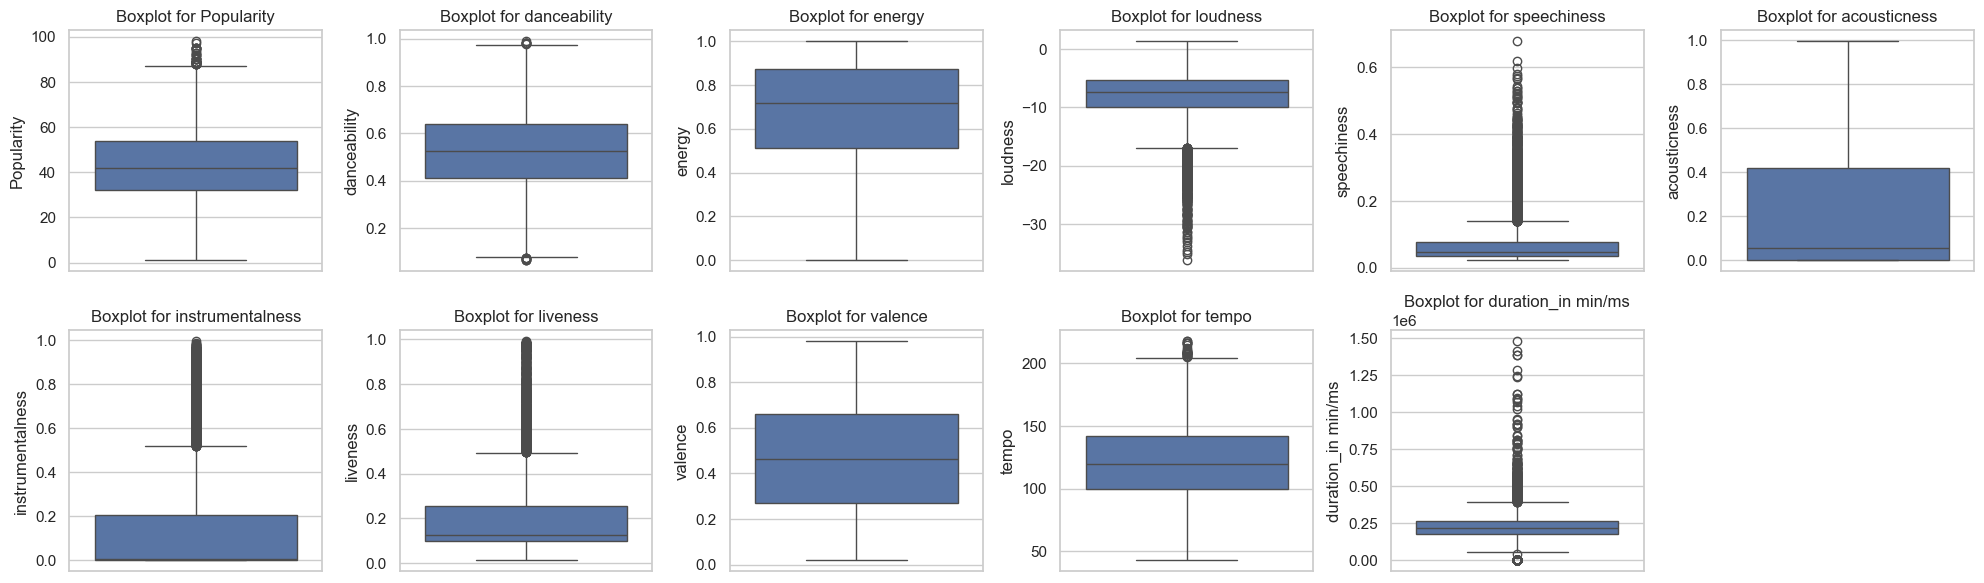

In [7]:
sns.set(style="whitegrid")
numerical_columns = ['Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 
                     'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 
                     'duration_in min/ms']

plt.figure(figsize=(20, 6))
for i, column in enumerate(numerical_columns):
    plt.subplot(2, 6, i+1)
    sns.boxplot(y=cleaned_data[column])
    plt.title(f"Boxplot for {column}")
    plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

Стало немного получше. Будем с этим работать

### Задание 2. Обучение дерева решений (10 баллов)

Предобработайте признаки так, чтобы их можно было подать в модель дерева решений и обучите ее, постарайтесь подобрать оптимальные гиперпараметры, которые вам известны. Постарайтесь также обосновать выбор метрики в данном случае. При подборе гиперпараметров может помочь `GridSearchCV` [ссылка](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html).

Дропаем столбцы 'Artist Name', 'Track Name' потому что это строковые значения, и они не помогут нам в предсказании

In [8]:
X = cleaned_data.drop(['Class', 'Artist Name', 'Track Name'], axis=1)
y = cleaned_data['Class']

In [9]:
numeric_features = 'Popularity', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_in min/ms'
categorical_features = 'key', 'mode', 'time_signature'
X_numeric = cleaned_data[list(numeric_features)]
X_categorical = cleaned_data[list(categorical_features)]
X = pd.concat([X_numeric, pd.get_dummies(X_categorical)], axis=1)
y = cleaned_data['Class']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(random_state=42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 3, 5, 7, 10, 12],
    'min_samples_split': [2, 5, 7, 10, 12],
    'min_samples_leaf': [1, 3, 5, 7]
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5, scoring='accuracy')

grid_search.fit(X_train, y_train)

print("Best Parameters:", grid_search.best_params_)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Best Parameters: {'criterion': 'entropy', 'max_depth': 7, 'min_samples_leaf': 3, 'min_samples_split': 7}
Accuracy: 0.4669771380186283


Как-то средненько получилось, но что есть. Можно еще визуализировать дерево

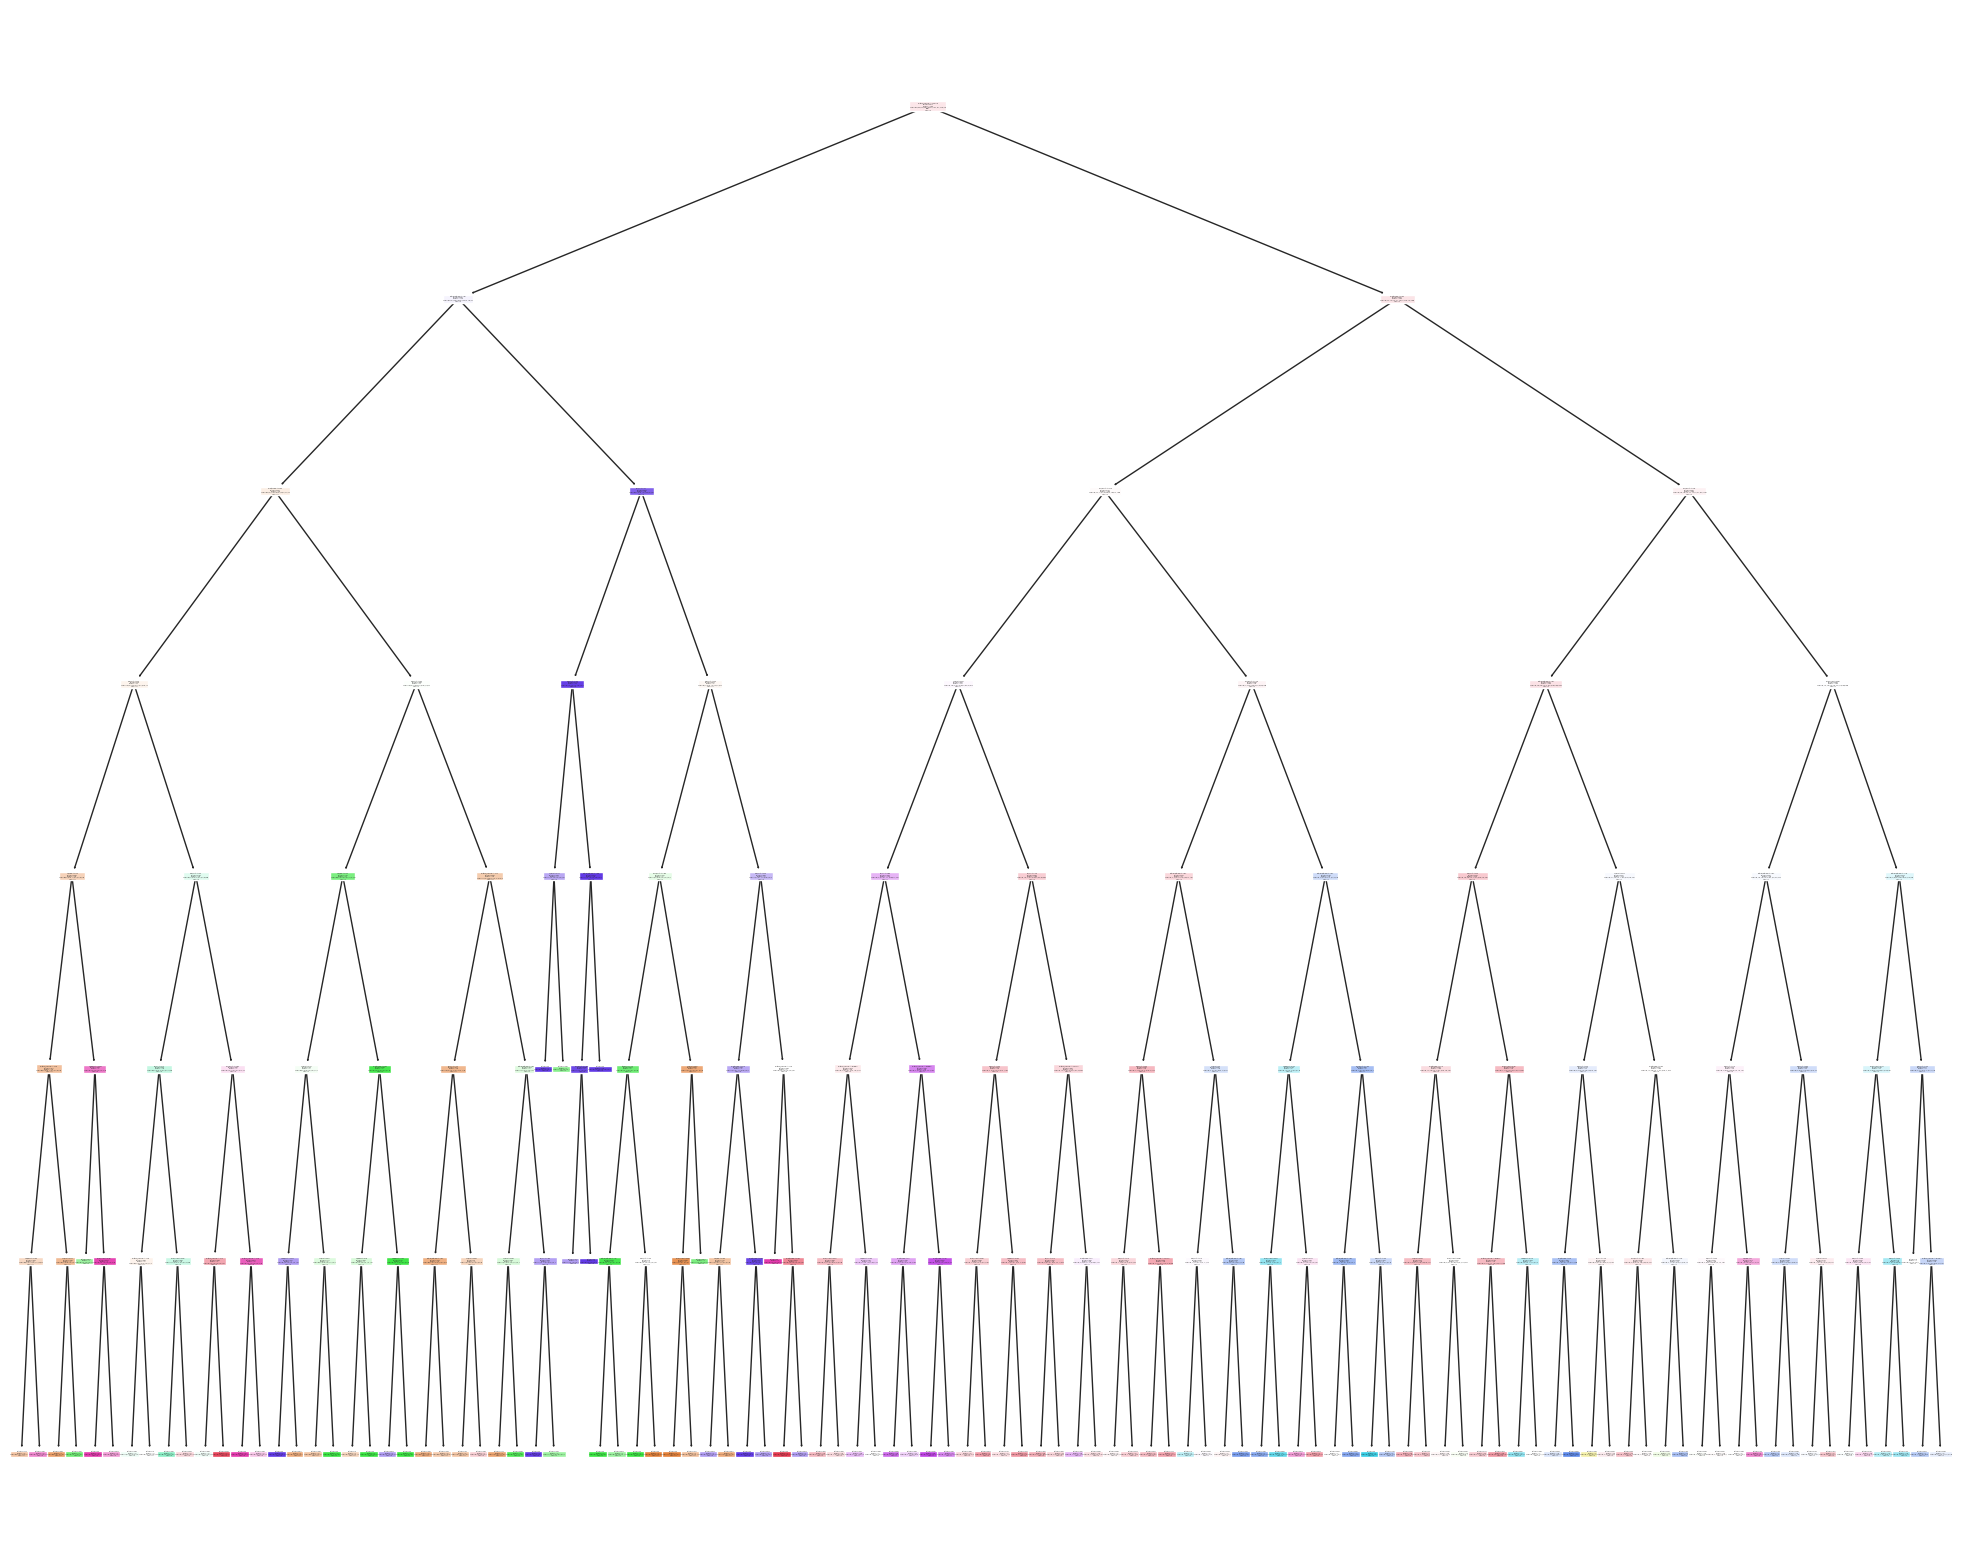

In [10]:
class_names = y.unique().astype(str)
plt.figure(figsize=(25, 20))
_ = plot_tree(best_model, 
              feature_names=X.columns,  
              class_names=class_names,
              filled=True)

plt.show()

### Задание 3. Другие модели (без баллов, просто если есть желание)

Проделайте операции из **Задания 2** с другими известными вам классификаторами. Стало ли лучше?

### Задание 4. (0.5 доп. балла)

Расскажите про свои любимые фильмы, мультики и тд.

1. Песнь моря - очень красиво нарисованный ирландский мульфильм про потерю близких 

2. Кролик Джоджо - красочное пособие по тому, как государства создают образ врага, а люди - разрушают его через личное общение и новые знания (с) Дудь

3. Моана - eto ya, если бы была Диснеевской принцесой и пела песни на морях :)